# Assignment "Assignment" System for DCT Academy's Code Platform

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import random
import requests
import json

## Creating list of dataframe of all tables, a dictionary mapping to corresponding dataframe

In [4]:
# Dictionary of all the tables and their columns
table_columns = {}

# Dictionary of all dataframes mapped with table names
df_all = {}

# List of all dataframes of all tables
df_list = []

request_tables = ['submissions', 'assignments', 'tags', 'taggings']

for table in request_tables:
    url = 'http://code.dctacademy.com/api/v1/ml/data/' + table + '?key=6eccc23db96ed84fce329e0d20bdacb4'
    response = requests.get(url)
#     print(response.status_code, response.reason)
    df_all[table] = pd.read_json(response.content)
    
model_path = '../ml-api/model/'

## Get all student/user assignments
### Merge submissions, assignments, taggings, tags

In [50]:
user_submissions = df_all['submissions'] \
    .merge(df_all['assignments'], left_on='assignment_id', right_on='id', suffixes=('_submissions', '_assignments')) \
    .merge(df_all['taggings'], left_on='id_assignments', right_on='taggable_id', suffixes=('_sub_ass', '_taggings')) \
    .merge(df_all['tags'], left_on='tag_id', right_on='id', suffixes=('_sub_ass_tag', '_tags')) 

submission_assignments = df_all['submissions'] \
    .merge(df_all['assignments'], left_on='assignment_id', right_on='id', suffixes=('_submissions', '_assignments'))

user_submissions.drop(['statement', 'output', 'language', 'created_at_submissions', 'updated_at_submissions', 'is_checked', 'body', 'url', 
                       'created_at_assignments', 'updated_at_assignments', 'pass', 'fail', 'tagger_type', 'created_at', 'total', 'practice_id', 
                       'assignment_id', 'user_id_assignments', 'code_assignments', 'tagger_id', 'tag_id', 'source', 'input_size',
                       'approved', 'function_name', 'context', 'id_sub_ass_tag', 'taggings_count', 'is_allowed', 'video_url', 'code_submissions', 'display_helper'], axis=1, inplace=True)

In [51]:
user_submissions.columns

Index(['id_submissions', 'points_submissions', 'time_in_seconds',
       'user_id_submissions', 'id_assignments', 'is_front_end', 'minutes',
       'points_assignments', 'title', 'taggable_id', 'taggable_type',
       'id_tags', 'name'],
      dtype='object')

In [52]:
user_submissions.head()

,id_submissions,points_submissions,time_in_seconds,user_id_submissions,id_assignments,is_front_end,minutes,points_assignments,title,taggable_id,taggable_type,id_tags,name
0,5,0.0,0,11,13,False,10,10,Merge two strings,13,Assignment,2,easy
1,4,0.0,0,13,13,False,10,10,Merge two strings,13,Assignment,2,easy
2,13,0.0,0,18,13,False,10,10,Merge two strings,13,Assignment,2,easy
3,14,0.0,0,17,13,False,10,10,Merge two strings,13,Assignment,2,easy
4,12,0.0,0,19,13,False,10,10,Merge two strings,13,Assignment,2,easy


In [53]:
user_submissions.describe().round()

,id_submissions,points_submissions,time_in_seconds,user_id_submissions,id_assignments,minutes,points_assignments,taggable_id,id_tags
count,37634.0,37634.0,37634.0,37634.0,37634.0,37634.0,37634.0,37634.0,37634.0
mean,4324.0,10.0,184606.0,96.0,186.0,15.0,14.0,186.0,17.0
std,2736.0,7.0,935167.0,53.0,155.0,9.0,6.0,155.0,10.0
min,1.0,0.0,-404943.0,3.0,13.0,5.0,10.0,13.0,1.0
25%,1719.0,5.0,457.0,52.0,37.0,10.0,10.0,37.0,10.0
50%,4359.0,10.0,1549.0,84.0,131.0,15.0,10.0,131.0,16.0
75%,6735.0,10.0,19882.0,141.0,348.0,20.0,20.0,348.0,20.0
max,9112.0,50.0,16335600.0,226.0,489.0,60.0,50.0,489.0,41.0


In [54]:
user_submissions.dropna(inplace=True)

In [ ]:
user_submissions_low = user_submissions[(user_submissions['time_in_seconds'] < 300)]
user_submissions = user_submissions[(user_submissions['time_in_seconds'] > 300)]

In [56]:
user_submissions.describe().round()

,id_submissions,points_submissions,time_in_seconds,user_id_submissions,id_assignments,minutes,points_assignments,taggable_id,id_tags
count,31259.0,31259.0,31259.0,31259.0,31259.0,31259.0,31259.0,31259.0,31259.0
mean,4443.0,10.0,223185.0,98.0,187.0,16.0,14.0,187.0,17.0
std,2739.0,8.0,1021785.0,53.0,156.0,9.0,7.0,156.0,10.0
min,15.0,0.0,301.0,3.0,13.0,5.0,10.0,13.0,1.0
25%,1893.0,5.0,830.0,54.0,37.0,10.0,10.0,37.0,10.0
50%,4546.0,10.0,2563.0,87.0,131.0,15.0,10.0,131.0,16.0
75%,6867.0,10.0,44718.0,144.0,349.0,20.0,20.0,349.0,22.0
max,9112.0,50.0,16335600.0,219.0,489.0,60.0,50.0,489.0,41.0


In [57]:
user_submissions_low.describe().round()

,id_submissions,points_submissions,time_in_seconds,user_id_submissions,id_assignments,minutes,points_assignments,taggable_id,id_tags
count,6366.0,6366.0,6366.0,6366.0,6366.0,6366.0,6366.0,6366.0,6366.0
mean,3741.0,9.0,-4565.0,86.0,183.0,13.0,12.0,183.0,17.0
std,2646.0,5.0,18141.0,51.0,149.0,6.0,4.0,149.0,10.0
min,1.0,0.0,-404943.0,3.0,13.0,5.0,10.0,13.0,1.0
25%,1321.0,5.0,100.0,46.0,34.0,10.0,10.0,34.0,10.0
50%,3270.0,10.0,170.0,71.0,144.0,10.0,10.0,144.0,16.0
75%,6030.0,10.0,228.0,123.0,343.0,20.0,10.0,343.0,18.0
max,9108.0,50.0,299.0,226.0,487.0,60.0,50.0,487.0,41.0


In [61]:
user_submissions_low.quantile(0.01)

id_submissions            10.0
points_submissions         0.0
time_in_seconds       -85035.0
user_id_submissions        3.0
id_assignments            13.0
is_front_end               0.0
minutes                    5.0
points_assignments        10.0
taggable_id               13.0
id_tags                    2.0
Name: 0.01, dtype: float64

In [ ]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='30')
plt.hist(user_submissions_low['time_in_seconds'], bins=np.arange(-500000, 300, 1000))
plt.title('Distribution of Time for submissions')
plt.xlabel('Time distribution')
plt.ylabel('No of Assignments')
plt.show()

In [12]:
user_submissions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37634 entries, 0 to 37633
Data columns (total 13 columns):
id_submissions         37634 non-null int64
points_submissions     37634 non-null float64
time_in_seconds        37634 non-null int64
user_id_submissions    37634 non-null int64
id_assignments         37634 non-null int64
is_front_end           37634 non-null bool
minutes                37634 non-null int64
points_assignments     37634 non-null int64
title                  37634 non-null object
taggable_id            37634 non-null int64
taggable_type          37634 non-null object
id_tags                37634 non-null int64
name                   37634 non-null object
dtypes: bool(1), float64(1), int64(8), object(3)
memory usage: 3.8+ MB


In [13]:
user_submissions['name'] = user_submissions['name'].str.strip().replace('/',',')

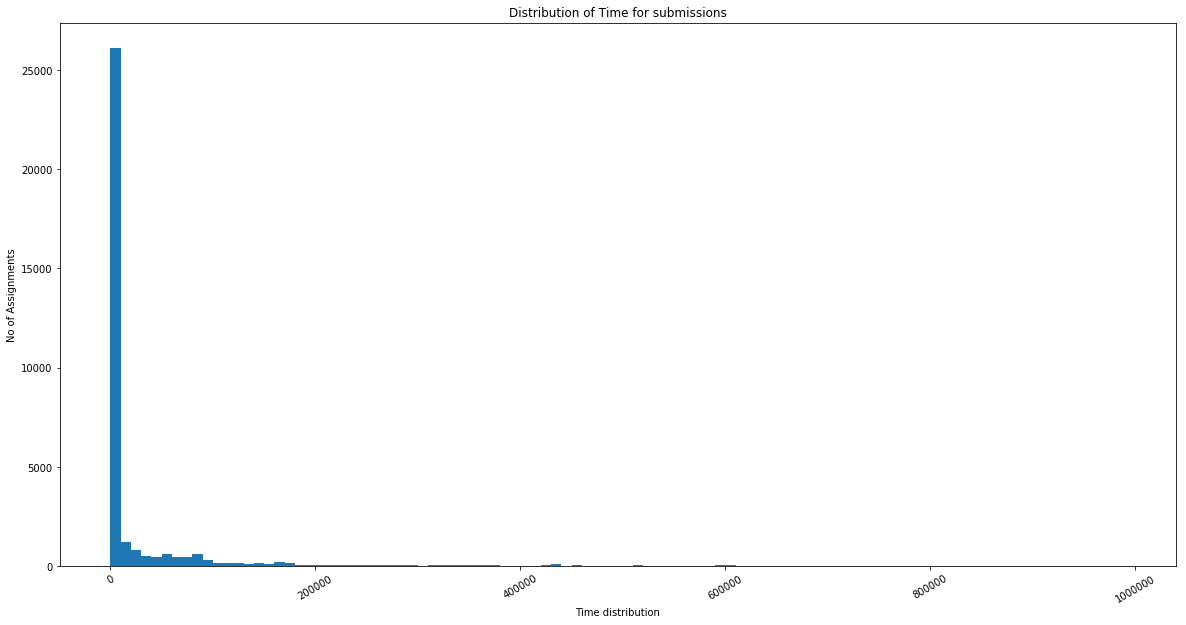

In [31]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='30')
plt.hist(user_submissions['time_in_seconds'], bins=np.arange(0, 1000000, 10000))
plt.title('Distribution of Time for submissions')
plt.xlabel('Time distribution')
plt.ylabel('No of Assignments')
plt.show()

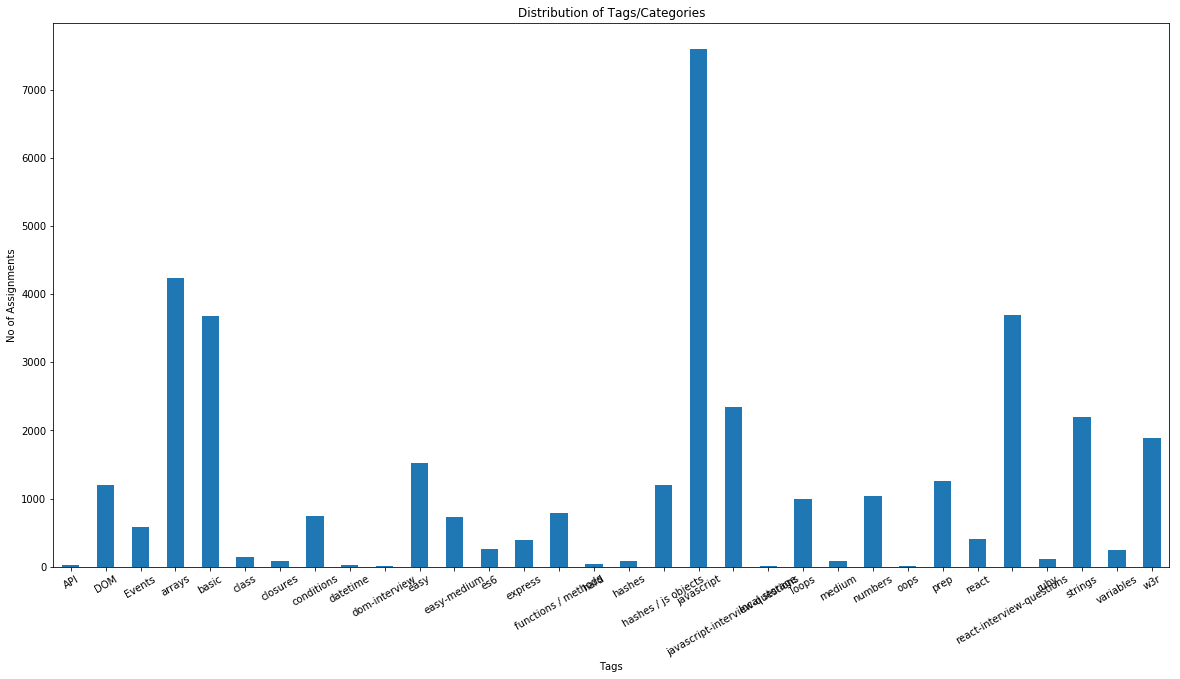

In [26]:
plt.figure(figsize=(20, 10))
user_submissions.groupby(['name']).count()['time_in_seconds'].plot(kind='bar')
plt.xticks(rotation='30')
plt.title('Distribution of Tags/Categories')
plt.xlabel('Tags')
plt.ylabel('No of Assignments')
plt.show()